In [10]:
import numpy as np
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys

In [ ]:
sys.path.append('..')
import dataloader
importlib.reload(dataloader)
from dataloader import DataLoader
importlib.reload(DataLoader)
DL = DataLoader.DataLoader()
DL.process_raw_data()

a done. total 1209 samples now
b done. total 2202 samples now
c done. total 3039 samples now
d done. total 3909 samples now
e done. total 4347 samples now
f done. total 4828 samples now
g done. total 5457 samples now
h done. total 5976 samples now
i done. total 6173 samples now
j done. total 7009 samples now
k done. total 7808 samples now
l done. total 8511 samples now
m done. total 9819 samples now
n done. total 10763 samples now
o done. total 10959 samples now
p done. total 11557 samples now
q done. total 11631 samples now


In [14]:
tree = ET.parse('F:\\Documents\\学习资料\\自动配和弦\\datasets\\xml\\a\\aage-aleksandersen\\fire-pils-og-en-pizza/chorus.xml')
root = tree.getroot()
meta = root.find('meta')
key = meta.find('key')
key.text

'C'

In [28]:
with open('F:\\Documents\\学习资料\\自动配和弦\\datasets\\event\\a\\aage-aleksandersen\\fire-pils-og-en-pizza/chorus_roman.json') as f:
    a = json.load(f)
a

'C'

In [4]:
a = np.load('F:\\Documents\\学习资料\\自动配和弦\\datasets\\pianoroll\\a\\aage-aleksandersen\\fire-pils-og-en-pizza/chorus.npz')

In [8]:
a.files

['tempo',
 'downbeat',
 'pianoroll_0_csc_data',
 'pianoroll_0_csc_indices',
 'pianoroll_0_csc_indptr',
 'pianoroll_0_csc_shape',
 'pianoroll_1_csc_data',
 'pianoroll_1_csc_indices',
 'pianoroll_1_csc_indptr',
 'pianoroll_1_csc_shape',
 'info.json']

In [15]:
a['pianoroll_0_csc_shape']

array([768, 128], dtype=int64)

In [33]:
multitrack = pr.read("F:\\Documents\\学习资料\\自动配和弦\\datasets\\pianoroll\\a\\above-and-beyond\\always/chorus_key.mid")
print(multitrack)

Multitrack(name=None, resolution=24, tempo=array(shape=(888, 1), dtype=float64), downbeat=array(shape=(888, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8)), StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8))])


In [40]:
multitrack = pr.read("F:\\Documents\\学习资料\\自动配和弦\\datasets\\pianoroll\\a\\above-and-beyond\\always/chorus_nokey.mid")
print(multitrack)

Multitrack(name=None, resolution=24, tempo=array(shape=(888, 1), dtype=float64), downbeat=array(shape=(888, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8)), StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8))])


In [41]:
multitrack.tracks[0].pianoroll

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

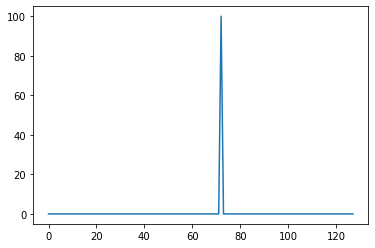

In [39]:
plt.plot(multitrack.tracks[0].pianoroll[97])

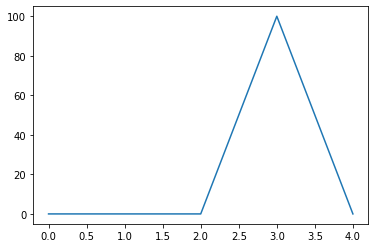

In [43]:
plt.plot(multitrack.tracks[0].pianoroll[97][60:65])

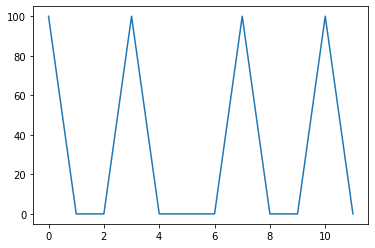

In [46]:
plt.plot(multitrack.tracks[1].pianoroll[97][48:60])

[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

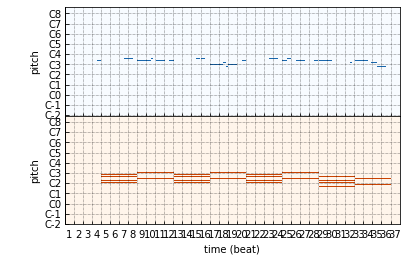

In [45]:
multitrack.plot()

In [29]:
128/11

11.636363636363637